$\text{Nome: Rafael Gonçalves  -  RA: 186062}$

# Parte I - Atividades teóricas

## Exercício 1

a) $P(A^C) = 1 - P(A) = 1 - \frac{1}{3} = \frac{2}{3}$

b) $P(A^C \cup B) = P(A^C) + P(B) - P(A^CB) = P(A^C) + P(B) - (P(B) - P(AB)) = P(A^C) + P(AB) = \frac{2}{3} + \frac{1}{6} = \frac{5}{6}$

c) $P(A \cup B^C) = P(A) + P(B^C) - P(AB^C) = P(B^C) + P(AB) = (1 - P(B)) + P(AB) = (1 - \frac{1}{4}) + \frac{1}{6} = \frac{5}{12}$

d) $P(AB^C) = P(A) + P(B^C) - P(A \cup B^C) = \frac{1}{3} + \frac{3}{4} - \frac{5}{12} = \frac{8}{12}$

e) $P(A^C \cup B^C) = P(A^C) + P(B^C) - P(A^CB^C) = \frac{2}{3} + \frac{3}{4} - \frac{5}{6} = \frac{7}{12}$

## Exercício 2

a) $$
    F_X(x) = P(X \leq x) = \int\limits_{-\infty}^x f_X(\xi) d\xi = \int\limits_{-\infty}^x \frac{1}{2} d\xi = \left[ \frac{1}{2}\xi \right]^x_0 = \frac{1}{2} x, \forall X \in [0, 2]
$$

b)

$E\{X\} = \int\limits_{-\infty}^{\infty} xf_X(x)dx = \int\limits_0^2 \frac{1}{2}x dx = \left[\frac{x^2}{4}\right]^2_0 = 1$

$E\{X^2\} = \int\limits_{-\infty}^{\infty} x^2f_X(x)dx = \int\limits_0^2 \frac{1}{2}x^2 dx = \left[\frac{x^3}{6}\right]^2_0 = \frac{4}{3}$

$E\{X^3\} = \int\limits_{-\infty}^{\infty} x^3f_X(x)dx = \int\limits_0^2 \frac{1}{2}x^3 dx = \left[\frac{x^4}{8}\right]^2_0 = 2$

## Exercício 3

a) $X_2$, pois quanto mais próximo da distribuição uniforme, mais difícil é acertar o resultado de um evento aleatório "chutando um valor", ou seja, a variável aleatória $X_2$ carrega mais informação que a variável aleatória $X_1$, pois neste último eu poderia supor que o resultado será sempre 3 com uma taxa de acertos de 40% contra uma taxa de acertos de 25% para qualquer valor estimado para $X_2$ se não tivermos nenhuma informação _a priori_.

b)

$H(X_1) = - \sum\limits_x p(X_1)log_2[p(X_1)] = -[0,1(-3,32) + 0,2(-2,32) + 0,3(-1,74) + 0,4(-1,32)] = 1,85$

$H(X_2) = - \sum\limits_x p(X_2)log_2[p(X_2)] = - [0,25 (-2) + 0,25 (-2) + 0,25 (-2) + 0,25(-2)] = 2$

c)

$D(P_1 || P_2) = \sum\limits_x p(X_1)log_2\left[\frac{p(X_1)}{p(X_2)}\right] = 0,1(-1,32) + 0,2(-0,32) + 0,3(-0,26) + 0,4(-0,68) = -0,54$

$D(P_2 || P_1) = \sum\limits_x p(X_2)log_2\left[\frac{p(X_2)}{p(X_1)}\right] = 0,25(1.32 +  0.32 - 0.26 -0.68) = 0,18$

## Exercício 4

a) $\mu_{ML} = arg max_\theta p(x|\mu) = arg max_\theta log[p(x|\mu)] = arg max_\theta \frac{p(x\mu)}{p(\mu)} = x$

b) $\mu_{ML} = arg max_\theta p(\mathbf{x}|\mu) = arg ax_\theta log[p(\mathbf{x}|\mu)] = arg max_\theta \sum\limits_{k=1}^{N} log[p(x_K|\mu)] =  arg max_\theta \sum\limits_{k=1}^{N} log\left[\frac{p(x_K\mu)}{p(\mu)}\right] $

c) 

# Parte II - Atividade computacional

### Importa bibliotecas

In [2]:
import os
import urllib.request
import random
random.seed = 42
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt
%matplotlib inline

### Download dataset

In [3]:
data_url = 'http://www.dca.fee.unicamp.br/~lboccato/sunspot.txt'
data_dir = os.path.abspath(os.path.relpath('../data'))
data_path = os.path.join(data_dir, 'sunspot.txt')

urllib.request.urlretrieve(data_url, data_path)

('/home/rafael/inbox/machine-learning/data/sunspot.txt',
 <http.client.HTTPMessage at 0x7f7ed644c748>)

In [4]:
%%bash
head ../data/sunspot.txt

 1749   58.0  62.6  70.0  55.7  85.0  83.5  94.8  66.3  75.9  75.5 158.6  85.2
 1750   73.3  75.9  89.2  88.3  90.0 100.0  85.4 103.0  91.2  65.7  63.3  75.4
 1751   70.0  43.5  45.3  56.4  60.7  50.7  66.3  59.8  23.5  23.2  28.5  44.0
 1752   35.0  50.0  71.0  59.3  59.7  39.6  78.4  29.3  27.1  46.6  37.6  40.0
 1753   44.0  32.0  45.7  38.0  36.0  31.7  22.0  39.0  28.0  25.0  20.0   6.7
 1754    0.0   3.0   1.7  13.7  20.7  26.7  18.8  12.3   8.2  24.1  13.2   4.2
 1755   10.2  11.2   6.8   6.5   0.0   0.0   8.6   3.2  17.8  23.7   6.8  20.0
 1756   12.5   7.1   5.4   9.4  12.5  12.9   3.6   6.4  11.8  14.3  17.0   9.4
 1757   14.1  21.2  26.2  30.0  38.1  12.8  25.0  51.3  39.7  32.5  64.7  33.5
 1758   37.6  52.0  49.0  72.3  46.4  45.0  44.0  38.7  62.5  37.7  43.0  43.0


### Importa dataset

In [5]:
dataset = np.loadtxt(data_path, usecols=range(1,13))

In [6]:
dataset.shape

(266, 12)

### Cria conjunto de teste e conjunto de treino

In [7]:
K = 20 # temporal window size
N = dataset.shape[0] # number of samples
M = N-K+1 # number of samples of new dataset
X = np.empty((M,K))
y = np.empty((M,1))

for i in range(M):
    for k in range(K):
        X[i][k] = dataset.flatten()[(i+K) - (k + 1)]
    y[i][0] = (dataset.flatten()[i+K])


In [8]:
X_train = np.array(X[:-5])
X_test = np.array(X[-5:])
y_train = np.array(y[:-5])
y_test = np.array(y[-5:])

In [9]:
X_train_bias = np.column_stack((np.ones(X_train.shape[0]), X_train))
X_test_bias = np.column_stack((np.ones(X_test.shape[0]), X_test))

In [10]:
X_train_bias.shape, X_test_bias.shape

((242, 21), (5, 21))

### Define RMSE como critério de erro

In [11]:
def rmse(output, target):
    """Root Mean Squared Error"""
    error = np.subtract(output, target)
    error = np.square(error)
    error = np.sum(error)/np.size(error)
    return np.sqrt(error)

### Regressão linear na forma matricial

In [12]:
linreg = lambda W, X: np.dot(X, W)

## a) Solução ótima com MMQ

In [13]:
mmq = lambda X, y: np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)

In [14]:
W_train = mmq(X_train_bias, y_train)
W_test = mmq(X_test_bias, y_test)

In [15]:
out_train = linreg(W_train, X_train_bias)
out_test = linreg(W_train, X_test_bias)

In [16]:
print("RMSE do conjunto de treino: {}\nRMSE do conjunto de teste: {}".format(rmse(out_train, y_train), rmse(out_test, y_test)))

RMSE do conjunto de treino: 13.972766440052313
RMSE do conjunto de teste: 28.492530791192834


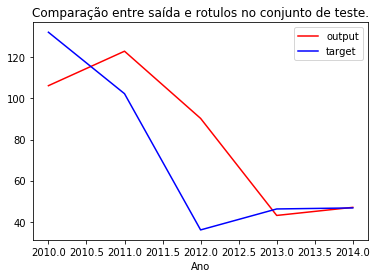

In [17]:
x_axis = [2010, 2011, 2012, 2013, 2014]
plt.plot(x_axis, out_test, '-r')
plt.plot(x_axis, y_test, '-b')
plt.xlabel('Ano')
plt.legend(('output', 'target'))
plt.title('Comparação entre saída e rotulos no conjunto de teste.')
plt.show()

## b) Seleção de variáveis, validação cruzada e regularização

In [18]:
def kfold(X, y, K, lamb_vec):
    N = X.shape[0]
    min_rmse = 999
    min_lamb = None
    for l in lamb_vec:
        error = 0
        for i in range(K):
            slic = range(int(i*N/K),int((i+1)*N/K))
            Xprime = X[slic,:]
            target = y[slic]
            w = np.dot(np.dot(np.linalg.inv(np.dot(Xprime.T, Xprime) + l*np.eye(Xprime.shape[1])), Xprime.T), target)
            out = linreg(w, Xprime)
            error += rmse(out, target)            
        error /= K    
        if error <= min_rmse:
            min_rmse = error
            min_lamb = l
    return (min_rmse, min_lamb)
    

In [19]:
def wrapper(X, y, N, K, lamb_vec):
    """Backward selection of the N inputs using K fold cross validation for choosing ridge regression hyperparameters."""
    for i in range(N):
        Xprime = X[:,:X.shape[1]-i]
        (error, lamb) = kfold(Xprime, y, K, lamb_vec)
        print("N = {}".format(i))
        print("min RMSE = {}\nlambda = {}\n".format(error, lamb))        

In [20]:
lamb_vec = [np.random.random()*0.001 + 1E-7 for _ in range(100)]
wrapper(X_train_bias, y_train, 20, 10, lamb_vec)

N = 0
min RMSE = 4.974832546037154
lambda = 3.112155095389534e-07

N = 1
min RMSE = 5.78979529199447
lambda = 3.112155095389534e-07

N = 2
min RMSE = 6.206328465057716
lambda = 3.112155095389534e-07

N = 3
min RMSE = 6.9431899061937115
lambda = 3.112155095389534e-07

N = 4
min RMSE = 7.410169492210628
lambda = 3.112155095389534e-07

N = 5
min RMSE = 7.855196313331431
lambda = 3.112155095389534e-07

N = 6
min RMSE = 8.008427035342915
lambda = 3.112155095389534e-07

N = 7
min RMSE = 8.337138810743213
lambda = 3.112155095389534e-07

N = 8
min RMSE = 8.89993206722404
lambda = 3.112155095389534e-07

N = 9
min RMSE = 9.096362690299493
lambda = 3.112155095389534e-07

N = 10
min RMSE = 9.483113014028786
lambda = 3.112155095389534e-07

N = 11
min RMSE = 9.953868097663113
lambda = 3.112155095389534e-07

N = 12
min RMSE = 10.392557867282484
lambda = 3.112155095389534e-07

N = 13
min RMSE = 10.653231841910813
lambda = 3.112155095389534e-07

N = 14
min RMSE = 11.099920252674867
lambda = 3.112155095

In [21]:
l = 3.58E-6
Xprime = X_train_bias
target = y_train
w = np.dot(np.dot(np.linalg.inv(np.dot(Xprime.T, Xprime) + l*np.eye(Xprime.shape[1])), Xprime.T), target)

In [22]:
out_test = linreg(w, X_test_bias)

In [23]:
print(rmse(out_test, y_test))

28.49253087010682


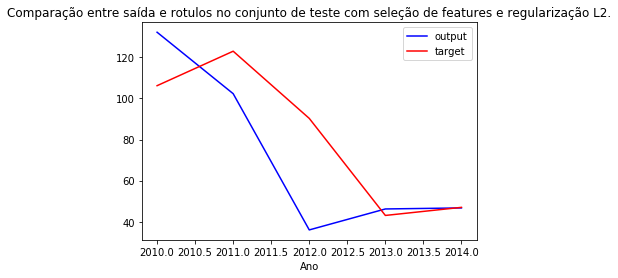

In [24]:
x_axis = [2010, 2011, 2012, 2013, 2014]
plt.plot(x_axis, y_test, '-b')
plt.plot(x_axis, out_test, '-r')
plt.xlabel('Ano')
plt.legend(('output', 'target'))
plt.title('Comparação entre saída e rotulos no conjunto de teste com seleção de features e regularização L2.')
plt.show()